<a href="https://colab.research.google.com/github/kunalkishanmehta/ns-struc-dm/blob/master/Two_fluid_code_clean_sly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

In [ ]:
import numpy as np # import packages
import matplotlib.pyplot as plt
import scipy.interpolate
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

In [ ]:
# download and install the code

%%bash
# make this cell an instance of a terminal

git clone https://github.com/kunalkishanmehta/ns-struc-dm.git # download code repository from https://github.com/landryp/ns-struc/tree/enthalpy
python2 -m pip install scipy

mkdir /opt/bin /opt/lib/ /opt/lib/python2.7 /opt/lib/python2.7/site-packages # create install directory and make it findable
export PATH=$PATH:/opt/bin
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

cd /content/ns-struc-dm # install code
python2 setup.py install --prefix /opt/

echo -e '\n *** \n'

getnsprops -h # this is the executable from ns-struc that solves the TOV equations to compute neutron star observables; print its help string to see the syntax for calling it

echo -e '\n *** \n'

In [ ]:
%%bash
export PATH=$PATH:/opt/bin
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

cd /content/ns-struc-dm # install code
git pull
python2 setup.py install --prefix /opt/



In [ ]:
# calculate neutron star observables for a given equation of state

%%bash
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops sly.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -r 0.,12. -n 48 -R 0.,12. # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Process is interrupted.


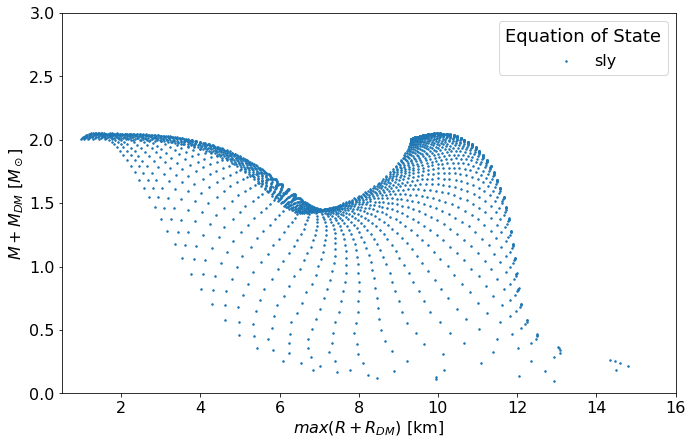

In [ ]:
# load the table of neutron star observablesthat was created above
mrl_data_sly = np.genfromtxt('/content/macro-sly.csv',delimiter=',',names=True,dtype=None)


plt.figure(figsize= (11,7))

plt.scatter(mrl_data_sly['R'],(mrl_data_sly['Mg']), label = 'sly', marker = 'p', s =3)


plt.xlim(0.5,16.)
plt.ylim(0.,3.)
plt.xlabel(r'$max(R+R_{DM})$ [km]', size = 16) # add plot labels, etc.
plt.ylabel(r'$M+M_{DM}$ [$M_\odot$]', size = 16)
plt.legend(fontsize = 16, title='Equation of State',title_fontsize=18 , loc = 'upper right')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

In [ ]:
def filter_R(data,model,n):

  lim = np.argmax((data['M']+data['Mdm']))
  # plt.scatter(np.maximum(data['R'][:lim+10],data[:lim+10]['Rdm']),((data['M']+data['Mdm'])[:lim+10]), label = '{}'.format(model), marker = 'p')
  
  for i in range(len(data)):
    if data['R'][i] < data['Rdm'][i]:
      plt.scatter(data['R'][i],(data['M']+data['Mdm'])[i], marker = '.', color = 'lawngreen', s =3)
    elif data['R'][i] > data['Rdm'][i]:
      plt.scatter(data['R'][i],(data['M']+data['Mdm'])[i], marker = '.', color = 'm', s=3)
    else:
      plt.scatter(data['R'][i],(data['M']+data['Mdm'])[i], marker = 'o', color = 'b', s=3)

  # plt.plot(data['R'][0::n],(data['M']+data['Mdm'])[0::n], label = '{} R0'.format(model), color = 'k')
  plt.scatter(data['R'][0::n],(data['M']+data['Mdm'])[0::n], label = '{} R0'.format(model), color = 'k', s = 10)

  return

In [ ]:
def filter_fdm(data,model,n):

  # lim = np.argmax((data['M']+data['Mdm']))
  # plt.scatter(np.maximum(data['R'][:lim+10],data[:lim+10]['Rdm']),((data['M']+data['Mdm'])[:lim+10]), label = '{}'.format(model), marker = 'p')
  
  for i in range(len(data)):
    if data['fdm'][i] < 0.5:
      plt.scatter(data['R'][i],(data['Mg'])[i], marker = '.', color = 'm', s = 3)
    elif data['fdm'][i] > 0.5:
      plt.scatter(data['R'][i],(data['Mg'])[i], marker = '.', color = 'c', s = 3)
    else:
      plt.scatter(data['R'][i],(data['Mg'])[i], marker = '.', color = 'gray', s = 3)

  plt.scatter(data['R'][0::n],(data['Mg'])[0::n], label = '{} R0'.format(model), marker = 'o', color = 'k', s = 10)

  return

In [ ]:
def plots(data,i,n,R,model):
  
  plt.scatter(data['R'][i::n],(data['Mg'][i::n]), label = '{} R={}'.format(model,R))


  plt.xlim(8.,16.)
  plt.ylim(1.,3.)
  plt.xlabel(r'$max(R+R_{DM})$ [km]', size = 16) # add plot labels, etc.
  plt.ylabel(r'$M+M_{DM}$ [$M_\odot$]', size = 16)
  plt.legend(fontsize = 16, title='Equation of State',title_fontsize=18 )
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)
  return

In [ ]:
# load central density, radius and mass data (computed separately)

dat = np.genfromtxt('macro-sly.csv',delimiter=',',dtype=None,names=True)

In [ ]:
# to associate the dark matter fraction to each point in rhoc-rhocdm space, interpolate 3D (rhoc,rhocdm,fdm) data to get a function fdm(rhoc,rhocdm)

x = dat['rhoc'] # input data
y = dat['rhocdm']
z = dat['fdm']

X = np.linspace(0.1e14,3.1e15,1000) # the grid where we'll evaluate fdm(rhoc,rhocdm)
Y = np.linspace(0.1e14,3.1e15,1000)
x_grid, y_grid = np.meshgrid(X, Y)

outdat = scipy.interpolate.griddata((x,y),z,(x_grid,y_grid),'linear')
 # fdm evaluated on the grid, with one of three methods: nearest, linear, cubic

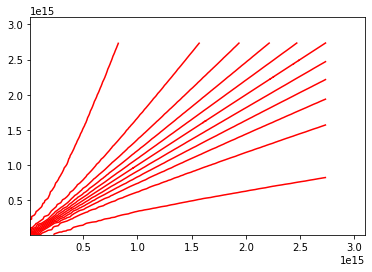

In [ ]:
# plot the interpolated fdm function 


num_cs = 9
cs = plt.contour(x_grid,y_grid,outdat,list(np.geomspace(1e-2,0.1,2))+list(np.linspace(0.1,0.9,num_cs)[1:])+list(reversed(1.-np.geomspace(1e-2,0.1,2)[:-1])),colors='r') # plot the contours of constant fdm(rhoc,rhocdm)



In [ ]:
# extract the (rhoc,rhocdm) coordinates of the constant-fdm contours

contours = []
for i in range(num_cs+3):
  try: c = cs.allsegs[i][0] # if a contour was plotted, save it
  except: continue
  contours += [c] # list that stores all the extracted contours




In [ ]:
# downsample the contours to get a list of (rhoc,rhocdm) coordinates to use to generate a constant-fdm sequence of stars

num_stars = 100 # how many stars to aim for in the sequence
rhocs, rhocdms = [], []

for c in contours:
  
  skip = int(len(c[:,0])/num_stars)
  rhocs += [c[::skip,0]]
  rhocdms += [c[::skip,1]] # downselect to num_stars (rhoc,rhocdm) points


rhomin = 2.8e14 # because some central densities are too small to give physical neutron stars, throw out those below rhomin
rhomax = 12*rhomin # because some central densities are too large to give physical neutron stars, throw out those above rhomax
rhocs_out, rhocdms_out = [], []

for c,cdm in zip(rhocs,rhocdms):
  c_out, cdm_out = [], []

  for rhoc,rhocdm in zip(c,cdm):
    
    if (rhoc >= rhomin or rhocdm >= rhomin) and rhoc <= rhomax and rhocdm <=rhomax: # one of rhoc/rhocdm below rhomin is ok, to allow pure regular matter or pure dm star
      c_out += [rhoc]
      cdm_out += [rhocdm]
  rhocs_out += [c_out]
  rhocdms_out += [cdm_out]

In [ ]:
def find_rhos(n):
  newrhoc = [str(r) for r in rhocs_out[n]]
  find_rhos.newrhocs_list = ','.join(newrhoc)

  newrhocdm = [str(r) for r in rhocdms_out[n]]
  find_rhos.newrhocdms_list = ','.join(newrhocdm)
  return find_rhos.newrhocs_list, find_rhos.newrhocdms_list


In [ ]:
find_rhos(0)

('305426365184764.1,328588588588588.6,347565720610673.0,371891891891891.94,390450450450450.5,403656970442030.56,422396019697135.56,444893869547574.75,467777777777777.8,492522522522522.56,510143839954154.9,526546546546546.56,549230462233169.8,572942942942943.0,597687687687687.8,623517138041546.5,643314484233471.8,666834695058069.1,687387387387387.4,709039039039039.1,733783783783783.9,755435435435435.5,780180180180180.2,801831831831831.9,823483483483483.5,845135135135135.2,866786786786786.9,891531531531531.5,916276276276276.4,937185434710682.8,959235982610774.2,981231231231231.2,1002882882882883.0,1027627627627627.8,1052372372372372.4,1074024024024024.1,1098768768768768.9,1123513513513513.8,1147083781684991.8,1172304899468521.0,1194654654654654.8,1219399399399399.5,1244144144144144.2,1268888888888889.0,1290540540540540.5,1314328109135544.2,1339449314072985.8,1361681681681681.8,1385865476673268.5,1408078078078078.2,1432822822822823.0,1457567567567567.5,1479219219219219.2,1503963963963964.

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops sly.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour0 -r $1 -n 10 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of sly stars
Start at central density 3.05426365185e+14 g/cm^3
Done at central density 2.72264264264e+15 g/cm^3
Save to /content/macro_contour0sly.csv


In [ ]:
find_rhos(1)

('291471471471471.5,319309309309309.3,347147147147147.2,369573932461717.1,393543543543543.56,415471465653697.56,439939939939939.94,461591591591591.6,486336336336336.4,511081081081081.1,538750090666533.3,558012150148267.4,585232596390306.6,613325603583618.0,634804804804804.9,659549549549549.6,687387387387387.4,709039039039039.1,733783783783783.9,758528528528528.6,786366366366366.5,808018018018018.0,832762762762762.8,860600600600600.8,883752078010547.0,908757868776711.0,934834834834835.0,959579579579579.5,984572055551942.9,1012162162162162.2,1036286361173123.9,1061651651651651.8,1089121502088759.8,1111141141141141.2,1135885885885886.0,1163516392698636.5,1191561561561561.8,1215499256852828.2,1240738061825787.0,1266664110857278.5,1291813365178890.8,1318378378378378.5,1342478313674770.0,1368548053673356.0,1394475857933518.5,1420450450450450.5,1445195195195195.0,1470768117914738.0,1497777777777778.0,1522522522522522.5,1549088486269116.5,1575105105105105.2,1599849849849850.0,1625565471587910.

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops sly.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour1 -r $1 -n 10 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of sly stars
Start at central density 2.91471471471e+14 g/cm^3
Done at central density 2.72573573574e+15 g/cm^3
Save to /content/macro_contour1sly.csv


In [ ]:
find_rhos(2)

('285285285285285.3,308824169913965.7,334774774774774.8,360762599599757.4,384861733083227.4,405082853146872.94,427567567567567.56,449967684029827.44,477057057057057.06,504981699587585.75,526780671192676.44,551820910203259.1,576036036036036.1,600780780780780.9,625525525525525.5,650270270270270.2,675015015015015.0,699408366363688.2,727597597597597.6,750830854186830.1,776127826138382.5,800530308086614.9,825995132491615.2,851321321321321.4,876066066066066.1,900314071237617.2,924535827776356.9,950300300300300.5,975045045045045.1,1002882882882882.8,1027627627627627.6,1052372372372372.5,1079100873418211.5,1101861861861861.8,1126606606606606.5,1151396562574210.5,1178997934032679.2,1203933933933934.0,1228678678678678.8,1255827055903646.0,1280149652576304.2,1306006006006006.0,1330750750750750.8,1355495495495495.5,1380751664395078.0,1408078078078078.2,1432822822822823.0,1457567567567567.8,1482312312312312.5,1509040774484311.0,1534894894894895.0,1559639639639639.8,1586797799571131.5,16114865709203

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops sly.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour2 -r $1 -n 10 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of sly stars
Start at central density 2.85285285285e+14 g/cm^3
Done at central density 2.71954954955e+15 g/cm^3
Save to /content/macro_contour2sly.csv


In [ ]:
find_rhos(3)

('303843843843843.9,331681681681681.7,353925034784281.44,381171171171171.2,401435899353673.1,426849427189259.94,452657597130493.2,480150150150150.2,504894894894894.94,529639639639639.7,554384384384384.44,578999967709767.8,604517145893811.9,628618618618618.6,653363363363363.4,679891894984555.0,705945945945946.0,730690690690690.8,755435435435435.5,780180180180180.2,805872663385129.6,832762762762762.8,857507507507507.5,884837767439040.0,910090090090090.1,934834834834834.9,960689854165508.9,984794879898830.2,1012162162162162.2,1036906906906906.9,1061651651651651.8,1086447229503170.0,1114234234234234.2,1138978978978979.0,1163723723723723.8,1190718270136939.2,1216306306306306.2,1241514744372560.8,1266162481092485.2,1292596268726802.8,1318378378378378.5,1343439730247694.5,1370147187063036.2,1395705705705706.0,1420450450450450.5,1446442394403729.5,1473033033033033.0,1497777777777777.8,1525114526547090.8,1550360360360360.5,1575105105105105.2,1601116859179209.0,1627687687687687.8,165243243243243

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops sly.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour3 -r $1 -n 10 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of sly stars
Start at central density 3.03843843844e+14 g/cm^3
Done at central density 2.7412012012e+15 g/cm^3
Save to /content/macro_contour3sly.csv


In [ ]:
find_rhos(4)

('303472219846304.5,328343183367531.75,353333333333333.4,377996907520610.44,401928229738242.2,430660660660660.7,455385166671255.0,481201266101030.25,507987987987988.0,532732732732732.75,557477477477477.5,582222222222222.2,610060060060060.1,634804804804804.9,662642642642642.5,687387387387387.4,712132132132132.1,737736519935092.6,764101362917868.8,790056542737595.5,816935969089616.1,842306963454037.1,869049725393114.0,894624624624624.6,919369369369369.4,946084177913422.2,971951951951952.0,997515136070180.8,1024534534534534.6,1049279279279279.4,1077072116816693.0,1101861861861861.9,1126809663576313.5,1154444444444444.5,1179370624614322.5,1207027027027027.0,1231771771771771.8,1257604790899111.5,1284354354354354.2,1309464111479948.0,1336281898267934.2,1361681681681681.8,1388665867539204.2,1414264264264264.2,1440053952325306.2,1466846846846847.0,1491591591591591.8,1518595210888075.8,1544174174174174.2,1570466424626085.5,1596756756756756.8,1622174089629991.8,1649339339339339.5,167408408408408

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops sly.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour4 -r $1 -n 10 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of sly stars
Start at central density 3.03472219846e+14 g/cm^3
Done at central density 2.71985434903e+15 g/cm^3
Save to /content/macro_contour4sly.csv


In [ ]:
find_rhos(5)

('316216216216216.25,353333333333333.4,390450450450450.56,418288381616173.9,439939939939939.94,458498574252008.94,492522522522522.56,532732732732732.75,572942942942943.0,613153153153153.1,647177177177177.2,668828826103360.6,687387387387387.4,709039039039039.1,727597600311037.1,749249249249249.2,780180180180180.2,817297297294916.8,835855855855855.9,857507507446099.8,876066066066066.1,897717717453808.4,916276276276276.4,941021021021021.1,975045045045045.1,1002882882882882.9,1021441442381312.8,1043093093093093.1,1074024024024024.1,1114234234234234.2,1154444444444444.5,1194654654654654.8,1228678678678678.8,1247237284951656.0,1268888888888889.0,1287447447447447.5,1309099096593971.8,1327657657657657.8,1355495495495495.5,1395705705705705.8,1435915915915916.0,1476126126126126.2,1516336336336336.5,1537987983297539.2,1556546546546546.8,1581291291291291.5,1618408408408408.5,1643153152945370.8,1661711711711711.8,1683363363194688.8,1701921921921922.0,1723573552939920.8,1742132132132132.2,1763783783

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops sly.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour5 -r $1 -n 10 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of sly stars
Start at central density 3.16216216216e+14 g/cm^3
Done at central density 2.7412012012e+15 g/cm^3
Save to /content/macro_contour5sly.csv


In [ ]:
find_rhos(6)

('272912912912912.94,297657657657657.7,321797940120966.56,347147147147147.2,371891891891891.94,393373405175543.5,418288288288288.25,439939939939939.94,464641685554660.06,489203262892011.8,513389042370490.9,537866776365159.1,559526994083252.25,582800663838875.2,606853954001900.8,629570287185944.9,653385887594436.0,678108108108108.1,702852852852853.0,725223660975172.2,749249249249249.2,771163946196237.0,795645645645645.8,818953011245845.8,842796739371962.1,866786786786787.0,890464008436581.4,913183183183183.2,936357126168294.8,959579579579579.6,984324324324324.2,1008147330266142.2,1030720720720720.8,1055274305557671.1,1077509434774366.4,1101836233714249.1,1124560496685337.6,1148258258258258.2,1172994615962572.2,1194654654654654.8,1219399399399399.5,1242160040870741.5,1265795795795795.5,1288728908059275.0,1312192192192192.2,1336771359181004.2,1358691929529256.2,1383333333333333.5,1405888503812208.8,1429729729729730.0,1452990560136169.0,1476126126126126.2,1500868396848776.2,152289013954303

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops sly.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour6 -r $1 -n 10 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of sly stars
Start at central density 2.72912912913e+14 g/cm^3
Done at central density 2.45663663664e+15 g/cm^3
Save to /content/macro_contour6sly.csv


In [ ]:
find_rhos(7)

('248342585597128.3,267166082060150.6,291471471471471.5,311933697200286.1,337867867867867.9,359519519519519.56,378078078078078.1,399773759610543.9,419771804021661.44,441130838500328.9,462303678681404.1,486336336336336.44,504894894894894.9,528969685034237.44,548198198198198.25,568346077719462.4,590846694297951.5,612122711489994.2,633098213839138.5,653363363363363.4,675015015015015.0,696335467411093.4,715225225225225.2,736876876876876.9,758329431252610.6,779986363370071.5,800021428550281.8,820390390390390.4,842042042042042.1,863693693693693.6,884004924135214.4,903903903903904.0,925249796777156.9,944596700524559.4,965765765765765.9,987417417417417.5,1008505831937911.2,1027627627627627.8,1049279279279279.4,1070930930930931.1,1091248426697321.2,1111141141141141.2,1131519300902931.5,1153075926911103.8,1173341185061005.0,1194654654654654.8,1215122035031290.2,1235474085053810.5,1256516516516516.5,1276986143226920.0,1297208399133670.5,1318378378378378.5,1340003060490908.5,1358764850780783.5,138

In [ ]:

# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops sly.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour7 -r $1 -n 10 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of sly stars
Start at central density 2.48342585597e+14 g/cm^3
Done at central density 2.22079493553e+15 g/cm^3
Save to /content/macro_contour7sly.csv


In [ ]:
find_rhos(8)

('205371974366136.3,223423423423423.44,239360136502625.03,260540540540540.56,279716532083009.88,300750750750750.75,321773261194134.4,340960960960961.0,359958034197016.7,378056255541321.2,393543543543543.56,412102102102102.06,430660660660660.7,450413961659390.5,468631280266548.5,486663561668084.7,504894894894894.94,526546546546546.56,544483114799373.7,561594308480254.06,579129129129129.1,595789535074432.0,616246246246246.2,634640057316310.9,653121600424843.0,671921921921921.9,690480480480480.5,708515854931749.5,725170876851846.8,743063063063063.1,760773862049119.2,779177077470492.5,797497028433623.0,815775536932560.8,834042930815591.2,851321321321321.4,869879879879880.0,887823663478705.4,904332113825894.4,922462462462462.6,941021021021021.1,959579579579579.6,977476109544241.2,994162938459577.9,1011831478603841.6,1030720720720720.8,1048909089978291.5,1066222679135928.1,1083396713528034.6,1101861861861861.9,1119577966013771.2,1136737635865706.2,1154444444444444.5,1172851874739955.0,119095

In [ ]:

# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops sly.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour8 -r $1 -n 10 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of sly stars
Start at central density 2.05371974366e+14 g/cm^3
Done at central density 1.92712911434e+15 g/cm^3
Save to /content/macro_contour8sly.csv


In [ ]:
find_rhos(9)

('177193618043907.7,191872275469026.5,204631904351782.84,220330330330330.34,238016423483012.1,252323899993669.28,266726726726726.75,288378378378378.4,301519864843831.6,316599826450414.1,337580175763925.3,353333333333333.4,368798798798798.75,378078078078078.1,398092472367732.4,414711096503393.75,428646869491919.5,442198006641655.6,458498498498498.5,476569300411846.6,492522522522522.56,507987987987988.0,523095121699114.56,535217574052890.94,551291291291291.3,566756756756756.8,582187991278366.6,596169251615228.2,610060060060060.1,622866798021237.1,640990990990991.0,654627883208380.9,668828828828828.9,685676661916453.8,700375942466823.6,715225225225225.2,729688508392161.1,743711071563722.0,758528528528528.6,770900900900901.0,786869838121601.1,801831831831831.9,817297297297297.5,831405767312527.0,845135135135135.1,860600600600600.6,875634597747040.9,888438438438438.5,901529276893542.6,916427022978360.2,931741741741741.8,946392130578964.4,960957669087486.5,975045045045045.1,989617131883454.2

In [ ]:

# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops sly.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour9 -r $1 -n 10 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of sly stars
Start at central density 1.77193618044e+14 g/cm^3
Done at central density 1.56560493091e+15 g/cm^3
Save to /content/macro_contour9sly.csv


In [ ]:
find_rhos(10)

('42044004054185.76,54878269350238.414,62348640818333.45,71861861861861.88,85976232001734.8,98965500890728.62,111896656552529.77,119989232782061.84,126117831737810.28,139843935118917.52,145256392038208.62,158468468468468.47,172144554274852.5,180120120120120.12,187076362218613.34,192572057366289.84,198678678678678.7,211051051051051.06,220330330330330.34,229609609609609.62,237068225179324.16,242661253579075.25,251658843887873.34,261814849372027.88,270577250112248.78,278143729658040.16,286900829577691.44,294909374393970.4,303843843843843.9,311294906212789.56,318723004376023.4,325321291107421.75,334978450286359.4,344823893348891.5,352887179618651.75,358929429894293.9,363830727017934.8,371358384816445.94,377606606442989.1,384264264264264.3,393543543543543.56,400876536563797.25,408729945960228.4,415195195195195.2,421654316434226.8,428861603783257.25,436846846846846.8,443033033033033.0,450342767917878.75,458498498498498.5,465298504957239.06,471660980650487.0,479158251889018.5,486602822179142.

In [ ]:

# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops sly.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour10 -r $1 -n 10 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of sly stars
Start at central density 4.20440040542e+13 g/cm^3
Done at central density 8.20847772447e+14 g/cm^3
Save to /content/macro_contour10sly.csv


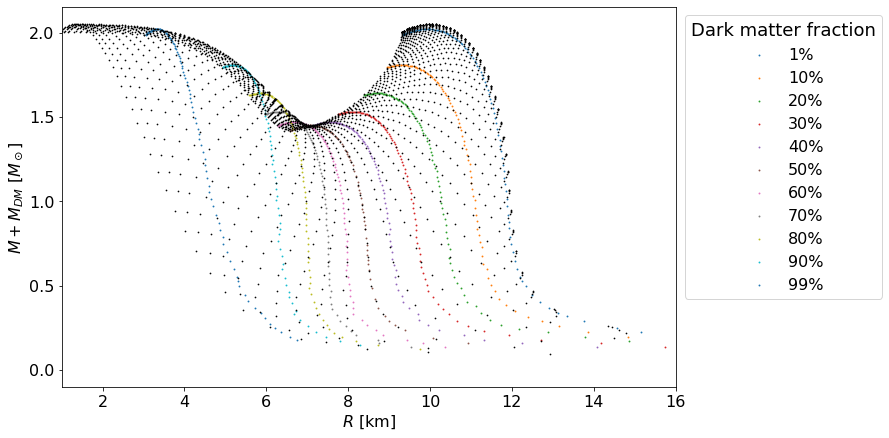

In [ ]:
data_con0 = np.genfromtxt('/content/macro_contour0sly.csv',delimiter=',',names=True,dtype=None)
data_con1 = np.genfromtxt('/content/macro_contour1sly.csv',delimiter=',',names=True,dtype=None)
data_con2 = np.genfromtxt('/content/macro_contour2sly.csv',delimiter=',',names=True,dtype=None)
data_con3 = np.genfromtxt('/content/macro_contour3sly.csv',delimiter=',',names=True,dtype=None)
data_con4 = np.genfromtxt('/content/macro_contour4sly.csv',delimiter=',',names=True,dtype=None)
data_con5 = np.genfromtxt('/content/macro_contour5sly.csv',delimiter=',',names=True,dtype=None)
data_con6 = np.genfromtxt('/content/macro_contour6sly.csv',delimiter=',',names=True,dtype=None)
data_con7 = np.genfromtxt('/content/macro_contour7sly.csv',delimiter=',',names=True,dtype=None)
data_con8 = np.genfromtxt('/content/macro_contour8sly.csv',delimiter=',',names=True,dtype=None)
data_con9 = np.genfromtxt('/content/macro_contour9sly.csv',delimiter=',',names=True,dtype=None)
data_con10 = np.genfromtxt('/content/macro_contour10sly.csv',delimiter=',',names=True,dtype=None)

# plot the surviving M-R data
plt.figure(figsize= (11,7))
# filter_fdm(dat,'sly',48)
plt.scatter(data_con0['R'],data_con0['Mg'],marker='.',s=3, label = '1%')
plt.scatter(data_con1['R'],data_con1['Mg'],marker='.',s=3, label = '10%')
plt.scatter(data_con2['R'],data_con2['Mg'],marker='.',s=3, label = '20%')
plt.scatter(data_con3['R'],data_con3['Mg'],marker='.',s=3, label = '30%')
plt.scatter(data_con4['R'],data_con4['Mg'],marker='.',s=3, label = '40%')
plt.scatter(data_con5['R'],data_con5['Mg'],marker='.',s=3, label = '50%')
plt.scatter(data_con6['R'],data_con6['Mg'],marker='.',s=3, label = '60%')
plt.scatter(data_con7['R'],data_con7['Mg'],marker='.',s=3, label = '70%')
plt.scatter(data_con8['R'],data_con8['Mg'],marker='.',s=3, label = '80%')
plt.scatter(data_con9['R'],data_con9['Mg'],marker='.',s=3, label = '90%')
plt.scatter(data_con10['R'],data_con10['Mg'],marker='.',s=3, label = '99%')
plt.scatter(dat['R'],dat['Mg'],marker='.',s=2,c='k')
plt.xlabel(r'$R$ [km]', size = 16) # add plot labels, etc.
plt.ylabel(r'$M+M_{DM}$ [$M_\odot$]', size = 16)
plt.xlim(1.,16.)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(bbox_to_anchor=(1.35, 1), fontsize = 16, title='Dark matter fraction',title_fontsize=18 )
plt.show()

In [ ]:
# to associate the (dark) baryon mass to each point in rhoc-rhocdm space, interpolate 3D (rhoc,rhocdm,Mb) data to get a function Mb(rhoc,rhocdm)

x = dat['rhoc'] # input data
y = dat['rhocdm']
z = dat['Mb']
zdm = dat['Md']

X = np.linspace(0.1e14,3.1e15,1000) # the grid where we'll evaluate Mb(rhoc,rhocdm)
Y = np.linspace(0.1e14,3.1e15,1000)
x_grid, y_grid = np.meshgrid(X, Y)

outdat = scipy.interpolate.griddata((x,y),z,(x_grid,y_grid),'linear') # Mb evaluated on the grid, with one of three methods: nearest, linear, cubic
outdat_dm = scipy.interpolate.griddata((x,y),zdm,(x_grid,y_grid),'linear') # Md evaluated on the grid

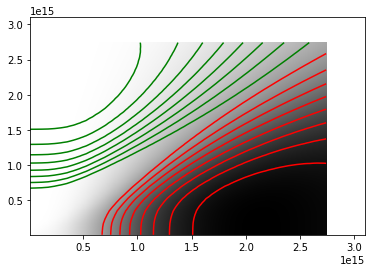

In [ ]:
# plot the interpolated Mb and Md functions

plt.pcolormesh(x_grid,y_grid,outdat,cmap='gray_r') # show Mb(rhoc,rhocdm) as a color map (darker = larger Mb)
#plt.pcolormesh(x_grid,y_grid,outdat,cmap='gray_r') # show Md(rhoc,rhocdm) as a color map (darker = larger Mb) -- but can't seem to show two colormaps at once

num_cs = 11
cs = plt.contour(x_grid,y_grid,outdat,list(np.linspace(1.,3.,num_cs)),colors='r') # plot the contours of constant Mb(rhoc,rhocdm)
cs_dm = plt.contour(x_grid,y_grid,outdat_dm,list(np.linspace(1.,3.,num_cs)),colors='g') # plot the contours of constant Md(rhoc,rhocdm)


In [ ]:
# extract the (rhoc,rhocdm) coordinates of the constant-fdm contours

contours = []
for i in range(num_cs+3):
  try: c = cs.allsegs[i][0] # if a contour was plotted, save it
  except: continue
  contours += [c] # list that stores all the extracted contours


In [ ]:
# downsample the contours to get a list of (rhoc,rhocdm) coordinates to use to generate a constant-fdm sequence of stars

num_stars = 100 # how many stars to aim for in the sequence
rhocs, rhocdms = [], []

for c in contours:
  
  skip = int(len(c[:,0])/num_stars)
  rhocs += [c[::skip,0]]
  rhocdms += [c[::skip,1]] # downselect to num_stars (rhoc,rhocdm) points


rhomin = 2.8e14 # because some central densities are too small to give physical neutron stars, throw out those below rhomin
rhomax = 12*rhomin # because some central densities are too large to give physical neutron stars, throw out those above rhomax
rhocs_out, rhocdms_out = [], []

for c,cdm in zip(rhocs,rhocdms):
  c_out, cdm_out = [], []

  for rhoc,rhocdm in zip(c,cdm):
    
    if (rhoc >= rhomin or rhocdm >= rhomin) and rhoc <= rhomax and rhocdm <=rhomax: # one of rhoc/rhocdm below rhomin is ok, to allow pure regular matter or pure dm star
      c_out += [rhoc]
      cdm_out += [rhocdm]
  rhocs_out += [c_out]
  rhocdms_out += [cdm_out]

In [ ]:
find_rhos(0)

('2741201201201202.0,2716456456456456.5,2691386627652767.5,2665793912958256.0,2641074390423345.0,2615422969542970.0,2590875242716255.5,2565865176017519.0,2540150150150150.5,2515914147389703.5,2491439468542276.0,2467318318546117.0,2442965807526425.5,2418122040552465.0,2394774774774775.0,2370030030030030.0,2345285285285285.5,2320540540540540.5,2296109110351215.5,2272709940880229.0,2249399399399399.5,2224654654654654.8,2200418607284778.5,2176555935582818.0,2153513513513513.8,2128768768768768.8,2106157730825615.0,2082372372372372.5,2058424227066051.2,2035975975975976.0,2011884147231775.5,1989485597643348.5,1964834834834835.0,1943183183183183.2,1919357766726959.5,1896786786786787.0,1873955994409662.0,1850390390390390.5,1828738738738738.8,1805246438955225.0,1782342342342342.5,1760690690690690.8,1739039039039039.2,1715346556944407.5,1693203820703897.2,1670990990990991.0,1649339339339339.5,1627687687687687.8,1605163915611370.8,1584315342087716.5,1562331070584463.5,1539866875788809.5,1519094808

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops sly.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour_mb0 -r $1 -n 4 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of sly stars
Start at central density 2.7412012012e+15 g/cm^3
Done at central density 6.73417341034e+14 g/cm^3
Save to /content/macro_contour_mb0sly.csv


In [ ]:
find_rhos(1)

('2741201201201201.5,2716456456456456.0,2691711711711712.0,2666966966966967.0,2642222222222222.5,2617953867979782.0,2594439009495984.0,2570911762082577.0,2546336336336336.5,2521591591591591.0,2497172524762658.0,2473814018545521.5,2450450450450450.5,2425705705705706.0,2401731518186817.0,2379236898100809.0,2354564564564564.5,2330434641337485.0,2308168168168168.5,2283505763650952.5,2261668649685859.5,2237027027027027.2,2214801200851802.0,2190630630630630.8,2167431837184786.0,2144234234234234.0,2121623466299811.0,2097837837837838.0,2076186186186186.0,2053032516583326.2,2029789789789790.0,2008138138138138.2,1984514108811665.0,1961741741741741.8,1940090090090090.5,1918438438438438.5,1896287050208112.0,1873224131251826.5,1850390390390390.5,1828738738738738.5,1807087087087087.2,1785435435435435.5,1763783783783784.0,1742039726879476.0,1720480480480480.5,1698828828828829.0,1677177177177177.2,1655525525525525.5,1633873873873874.0,1612222222222222.2,1590570570570570.8,1569540815607217.5,1549490297

In [ ]:
len(find_rhos.newrhocs_list)

1897

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops sly.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour_mb1 -r $1 -n 4 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of sly stars
Start at central density 2.7412012012e+15 g/cm^3
Done at central density 7.52969711832e+14 g/cm^3
Save to /content/macro_contour_mb1sly.csv


In [ ]:
find_rhos(2)

('2741201201201201.5,2716456456456456.5,2692281885955506.5,2670060060060060.0,2645315315315315.5,2621310125386093.0,2598918918918919.0,2574174174174174.0,2552522522522522.5,2527777777777778.0,2505607742092939.5,2481381381381381.5,2459173906599633.0,2434984984984985.0,2413333333333333.5,2388789122955882.0,2366936936936937.0,2343733910611258.0,2320540540540541.0,2298888888888889.0,2275946694536856.0,2252611607386421.0,2230840840840841.0,2209189189189189.2,2186021798802086.0,2162792792792793.0,2141141141141141.2,2119489489489489.5,2097837837837838.0,2075805421293477.8,2054108998825500.0,2031700965929443.8,2009430766044198.8,1987138779871828.8,1965542082497176.5,1943983733793112.0,1922492198205219.0,1901772695340203.0,1880783934909900.2,1859669669669669.8,1838018018018018.0,1816366366366366.5,1794714714714714.8,1773819427762495.8,1753388219986965.5,1732852852852853.0,1711201201201201.2,1690876008544253.5,1670990990990991.0,1649339339339339.8,1628739195116330.8,1609129129129129.0,1587657833

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops sly.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour_mb2 -r $1 -n 4 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of sly stars
Start at central density 2.7412012012e+15 g/cm^3
Done at central density 8.38559325131e+14 g/cm^3
Save to /content/macro_contour_mb2sly.csv


In [ ]:
find_rhos(3)

('2741201201201201.5,2719549549549549.5,2695163181103984.5,2673153153153153.5,2650587208632832.0,2626756756756757.0,2605105105105105.0,2582512599429675.5,2558708708708709.0,2537057057057057.0,2515405405405405.5,2492769911624850.5,2469688661322532.0,2447357357357357.5,2425705705705706.0,2404054054054054.0,2382402402402402.5,2360108579357152.0,2337519913740629.0,2315792953950861.5,2294380377043711.5,2272271393099924.0,2251349474503294.0,2230427555906663.2,2208948594760392.8,2187537537537538.0,2165885885885886.0,2144234234234234.2,2122582582582582.5,2100930930930931.0,2080328173568960.0,2060393251289164.0,2039069069069069.0,2017417417417417.5,1997376528452081.5,1977207207207207.2,1955555555555555.8,1934862736435619.2,1915345345345345.5,1893754812424621.8,1874617566913128.5,1853483483483483.5,1833848763911096.5,1813273273273273.2,1794085364695370.2,1773063063063063.5,1754299974196931.8,1733160866596102.2,1714294294294294.5,1694275925943207.5,1674084084084084.2,1655525525525525.5,1635984716

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops sly.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour_mb3 -r $1 -n 4 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of sly stars
Start at central density 2.7412012012e+15 g/cm^3
Done at central density 9.28082602288e+14 g/cm^3
Save to /content/macro_contour_mb3sly.csv


In [ ]:
find_rhos(4)

('2741201201201201.5,2719549549549549.5,2697897897897898.0,2676246246246246.5,2654553461902393.5,2631890731730653.0,2609678996117671.0,2587676375613517.0,2566256895558573.0,2544928342234116.0,2523564550271852.0,2502403393570640.5,2481381381381381.5,2459729729729730.0,2438078078078078.0,2416659578848897.5,2395185797192450.5,2374960902610998.5,2354564564564564.5,2332912912912913.0,2311261261261261.5,2290984265003285.5,2271051051051051.0,2249399399399399.5,2230391630099328.5,2209189189189189.2,2189200052880791.8,2168978978978979.0,2148010604375196.5,2128768768768769.0,2107176409780819.0,2088558558558558.8,2067726784202921.5,2048348348348348.5,2029630613493494.5,2008169758611475.0,1989579579579579.8,1970086755911188.2,1949755498828010.2,1930810810810811.0,1912252252252252.2,1892341460855031.0,1872163569835822.5,1853483483483483.5,1834924924924924.8,1816366366366366.5,1797807807807808.0,1779249249249249.2,1760690690690690.8,1742132063136754.2,1723573573573573.8,1705015015015015.0,1686456456

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops sly.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour_mb4 -r $1 -n 4 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of sly stars
Start at central density 2.7412012012e+15 g/cm^3
Done at central density 1.0298492245e+15 g/cm^3
Save to /content/macro_contour_mb4sly.csv


In [ ]:
find_rhos(5)

('2741201201201201.5,2719549549549549.5,2697897897897898.0,2676246246246246.5,2654594594594594.5,2632942942942943.0,2612215785413067.5,2592732732732733.0,2571081081081081.0,2549429429429429.5,2529362928632152.0,2509219219219219.5,2487567567567567.5,2466620452364270.0,2447357357357357.5,2426758559812597.5,2407147147147147.5,2385495495495495.5,2366936936936937.0,2345285285285285.5,2326726726726727.0,2307487330051403.5,2286516516516516.5,2267957957957958.0,2247688509453991.0,2227747747747747.8,2209189189189189.0,2190501862464243.5,2170443247946403.8,2150673031982782.0,2131861861861862.0,2113303303303303.2,2094744744744744.8,2076186186186186.0,2057627627627627.8,2038695927218486.5,2020412933099669.2,2001951951951952.0,1983393393393393.5,1964834834834835.0,1946276276276276.5,1927717717717717.8,1911091115046525.0,1893693693693693.8,1875135135135135.2,1856576576576576.8,1838018018018018.0,1820672019435706.5,1803993993993994.0,1785435435435435.5,1769969969969970.0,1751411411411411.5,1735029094

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops sly.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour_mb5 -r $1 -n 4 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of sly stars
Start at central density 2.7412012012e+15 g/cm^3
Done at central density 1.14705415356e+15 g/cm^3
Save to /content/macro_contour_mb5sly.csv


In [ ]:
find_rhos(6)

('2741201201201201.5,2719549549549549.5,2697897897897898.0,2676246246246247.0,2654594594594594.5,2632942942942943.0,2614384384384384.5,2592732732732733.0,2572611235644178.0,2552522522522522.5,2532187881627947.0,2512312312312312.5,2490660660660661.0,2472102102102102.0,2450869419186058.0,2431891891891892.0,2413333333333333.5,2392625286923924.5,2373123123123123.5,2354564564564564.5,2335973611555316.5,2315995310729103.0,2297111180414438.5,2278227050099773.0,2259590323822016.5,2241009433034184.0,2222428542246352.5,2205730666039375.5,2187537537537538.0,2168978978978979.0,2150420420420420.5,2131861861861862.0,2114492905485354.0,2097670367379023.8,2079279279279279.5,2060720720720721.0,2044667466064052.0,2026696696696696.8,2008608965774285.2,1992672672672672.5,1975147550896897.0,1958648648648648.5,1942054387172211.8,1924624624624625.0,1909159159159159.2,1893598397345922.0,1875135135135135.5,1859669669669670.0,1843053373989789.5,1825645645645645.8,1810180180180180.0,1794714714714714.8,1779249249

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops sly.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour_mb6 -r $1 -n 4 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of sly stars
Start at central density 2.7412012012e+15 g/cm^3
Done at central density 1.29512462803e+15 g/cm^3
Save to /content/macro_contour_mb6sly.csv


In [ ]:
find_rhos(7)

('2741201201201201.5,2721492112778759.0,2700990990990991.0,2679339339339339.5,2657687687687688.0,2636036036036036.0,2617477477477477.5,2598918918918919.0,2577267267267267.5,2555615615615616.0,2537057057057057.0,2518498498498498.5,2499939939939940.0,2481381381381381.5,2462822822822823.0,2444264264264264.5,2428798798798799.0,2410240240240240.5,2391681681681682.0,2376216216216216.5,2357657657657658.0,2342192192192192.5,2325817348639511.5,2308168168168168.5,2292702702702703.0,2277237237237237.5,2261771771771772.0,2246306306306306.5,2229324332105619.0,2212282282282282.5,2198703854330887.2,2184444444444444.5,2168978978978979.0,2153123872842799.8,2138048048048048.2,2122582582582582.8,2107117117117117.2,2091651651651651.8,2079236656383641.2,2063813813813813.8,2050461391556591.5,2035975975975976.0,2022038705527162.5,2008138138138138.2,1993826143570711.5,1980300300300300.5,1967927927927928.0,1954073158372328.0,1940090090090090.2,1927717717717717.8,1915345345345345.5,1902255112486712.5,1888441398

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops sly.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour_mb7 -r $1 -n 4 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of sly stars
Start at central density 2.7412012012e+15 g/cm^3
Done at central density 1.50965577781e+15 g/cm^3
Save to /content/macro_contour_mb7sly.csv


In [ ]:
data_con_mb0 = np.genfromtxt('/content/macro_contour_mb0sly.csv',delimiter=',',names=True,dtype=None)
data_con_mb1 = np.genfromtxt('/content/macro_contour_mb1sly.csv',delimiter=',',names=True,dtype=None)
data_con_mb2 = np.genfromtxt('/content/macro_contour_mb2sly.csv',delimiter=',',names=True,dtype=None)
data_con_mb3 = np.genfromtxt('/content/macro_contour_mb3sly.csv',delimiter=',',names=True,dtype=None)
data_con_mb4 = np.genfromtxt('/content/macro_contour_mb4sly.csv',delimiter=',',names=True,dtype=None)
data_con_mb5 = np.genfromtxt('/content/macro_contour_mb5sly.csv',delimiter=',',names=True,dtype=None)
data_con_mb6 = np.genfromtxt('/content/macro_contour_mb6sly.csv',delimiter=',',names=True,dtype=None)
data_con_mb7 = np.genfromtxt('/content/macro_contour_mb7sly.csv',delimiter=',',names=True,dtype=None)


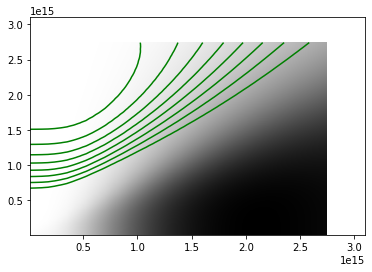

In [ ]:
# plot the interpolated Mb and Md functions

plt.pcolormesh(x_grid,y_grid,outdat,cmap='gray_r') # show Mb(rhoc,rhocdm) as a color map (darker = larger Mb)
#plt.pcolormesh(x_grid,y_grid,outdat,cmap='gray_r') # show Md(rhoc,rhocdm) as a color map (darker = larger Mb) -- but can't seem to show two colormaps at once

num_cs = 11
# cs = plt.contour(x_grid,y_grid,outdat,list(np.linspace(1.,3.,num_cs)),colors='r') # plot the contours of constant Mb(rhoc,rhocdm)
cs_dm = plt.contour(x_grid,y_grid,outdat_dm,list(np.linspace(1.,3.,num_cs)),colors='g') # plot the contours of constant Md(rhoc,rhocdm)


In [ ]:
contours_dm = []
for i in range(num_cs+1):
  try: c = cs_dm.allsegs[i][0] # if a contour was plotted, save it
  except: continue
  contours_dm += [c] # list that stores all the extracted contours


In [ ]:
# downsample the contours to get a list of (rhoc,rhocdm) coordinates to use to generate a constant-fdm sequence of stars

num_stars = 100 # how many stars to aim for in the sequence
rhocs, rhocdms = [], []

for c in contours_dm:
  
  skip = int(len(c[:,0])/num_stars)
  rhocs += [c[::skip,0]]
  rhocdms += [c[::skip,1]] # downselect to num_stars (rhoc,rhocdm) points


rhomin = 2.8e14 # because some central densities are too small to give physical neutron stars, throw out those below rhomin
rhomax = 12*rhomin # because some central densities are too large to give physical neutron stars, throw out those above rhomax
rhocs_out, rhocdms_out = [], []

for c,cdm in zip(rhocs,rhocdms):
  c_out, cdm_out = [], []

  for rhoc,rhocdm in zip(c,cdm):
    
    if (rhoc >= rhomin or rhocdm >= rhomin) and rhoc <= rhomax and rhocdm <=rhomax: # one of rhoc/rhocdm below rhomin is ok, to allow pure regular matter or pure dm star
      c_out += [rhoc]
      cdm_out += [rhocdm]
  rhocs_out += [c_out]
  rhocdms_out += [cdm_out]

In [ ]:
find_rhos(0)

('10000000000000.0,54776679163095.53,99699699699699.69,139909909909909.92,181581050475287.28,219592815925718.5,254354354354354.38,291471471471471.5,325495495495495.5,356426426426426.44,387357357357357.4,418288288288288.3,446126126126126.1,477057057057057.06,504894894894894.94,532732732732732.75,560570570570570.6,588408408408408.5,616246246246246.2,643640614619355.2,670657260077619.8,696666666666666.8,724504504504504.5,749249249249249.2,777087087087087.1,802857295369761.9,829669669669669.8,857507507507507.5,882252252252252.2,909969878149010.8,934834834834834.9,960654643848340.8,987417417417417.5,1012162162162162.2,1038513973884245.6,1064744744744744.8,1090035093640874.5,1115751052999025.5,1142072072072072.2,1166816816816817.0,1192075090211740.5,1218191496542511.5,1243647728649674.5,1268888888888889.0,1293633633633633.8,1318378378378378.5,1343123123123123.5,1369191934277265.5,1392612612612612.8,1418157942460757.8,1442359502730336.8,1466846846846847.0,1491591591591591.8,1516336336336336.5

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops sly.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour_md0 -r $1 -n 4 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of sly stars
Start at central density 1e+13 g/cm^3
Done at central density 2.58345345345e+15 g/cm^3
Save to /content/macro_contour_md0sly.csv


In [ ]:
find_rhos(1)

('10000000000000.0,53303303303303.305,93513513513513.52,133723723723723.73,173933933933933.94,210723549404778.62,245075075075075.1,279099099099099.12,310030030030030.06,344054054054054.06,371891891891891.94,399729729729729.75,427900096147588.9,455439885849469.25,483243243243243.25,511081081081081.1,537783476675166.2,563663663663663.8,588408408408408.5,613153153153153.1,637897897897897.9,662651810757768.4,687689054037189.5,712132132132132.1,736876876876876.9,761621621621621.6,786366366366366.4,809447470220094.9,832762762762762.8,857507507507507.5,881304375821993.4,903903903903904.0,928160458087387.2,950300300300300.4,975045045045045.0,998521663249403.5,1021441441441441.5,1044361300823149.1,1067837837837838.0,1089489489489489.5,1113420365012685.2,1135885885885886.0,1158362455510469.0,1182282282282282.2,1203933933933934.0,1226096442583246.0,1249209233707048.8,1271802915981388.2,1293633633633633.8,1315285285285285.2,1337258243501662.0,1360981757884355.0,1382867652200192.0,1404311255136674.

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops sly.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour_md1 -r $1 -n 4 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of sly stars
Start at central density 1e+13 g/cm^3
Done at central density 2.35338513338e+15 g/cm^3
Save to /content/macro_contour_md1sly.csv


In [ ]:
find_rhos(2)

('10000000000000.0,50210210210210.21,87327327327327.33,124444444444444.45,161561561561561.56,198678678678678.7,232702702702702.7,263633633633633.66,294564564564564.56,325495495495495.5,356426426426426.44,381171171171171.2,409009009009009.0,436846846846846.9,461591591591591.6,486336336336336.4,512660767443192.75,536903763550974.0,560570570570570.56,583600441090873.8,606966966966967.0,630458427713816.4,653363363363363.4,676273921070559.6,699759759759759.8,721411411411411.5,743063063063063.1,764714714714714.8,786366366366366.5,808018018018018.0,829669669669669.8,851321321321321.4,872972972972973.0,894624624624624.6,916276276276276.4,936794578773720.8,957389439833147.6,978138138138138.2,999789789789789.9,1020935435389811.2,1040510185089391.8,1061651651651651.8,1082644346459307.5,1101861861861861.8,1123104168824641.6,1142072072072072.2,1163546666381547.8,1182282282282282.2,1203933933933934.0,1222492492492492.5,1243589023514156.0,1262702702702702.8,1281261771072855.8,1302058048803870.0,13214

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops sly.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour_md2 -r $1 -n 4 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of sly stars
Start at central density 1e+13 g/cm^3
Done at central density 2.14423423423e+15 g/cm^3
Save to /content/macro_contour_md2sly.csv


In [ ]:
find_rhos(3)

('10000000000000.0,47117117117117.12,81141141141141.14,118258258258258.27,152282282282282.28,186306306306306.3,217237237237237.25,248168168168168.2,279099099099099.12,306936936936936.94,336517722902133.1,362612612612612.6,388782834278800.5,414435675738119.4,438173472608041.6,461591591591591.6,486336336336336.44,509469150575461.75,532732732732732.75,554384384384384.4,576036036036036.1,597687687687687.8,618172986299275.2,640177284970007.8,660314113164895.1,681201201201201.2,702852852852852.9,721411411411411.5,741368339379940.2,761621621621621.8,780594760102722.9,801831831831831.9,820390390390390.2,839168602831489.2,860275816123245.4,879159159159159.2,897717717717717.8,916276276276276.4,934834834834834.9,953393393393393.5,971951951951952.0,990510510510510.6,1009069069069069.1,1027627627627627.6,1046186186186186.2,1064744744744744.8,1082584157212262.0,1100089018030785.5,1117327327327327.4,1135885885885886.0,1154444444444444.5,1171697523543551.8,1188518886353316.5,1207027027027027.0,1224199

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops sly.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour_md3 -r $1 -n 4 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of sly stars
Start at central density 1e+13 g/cm^3
Done at central density 1.96293927909e+15 g/cm^3
Save to /content/macro_contour_md3sly.csv


In [ ]:
find_rhos(4)

('10000000000000.0,44024024024024.03,74954954954954.97,108978978978978.98,143003003003003.0,173933933933933.94,204864864864864.9,232702702702702.72,260540540540540.56,288724335942578.94,316216216216216.25,344054054054054.1,366749363295954.0,390450450450450.5,415195195195195.2,436846846846846.9,459261475107815.7,480809478934207.8,502150374294019.56,525035927972930.25,545105105105105.1,563663663663663.8,584366221525679.8,603873873873873.9,622432432432432.5,641719782322119.4,659959727446940.4,680779072175641.8,699759759759759.8,716960872953049.8,733802726057244.8,752342342342342.4,769742152510589.2,786366366366366.4,804924924924925.0,823479916482438.9,839527407580080.2,857507507507507.5,874801137283178.2,891310347806530.8,906996996996997.0,923686427487500.0,940925090678715.1,956486486486486.5,972587120921522.1,990443929462249.9,1005975975975976.1,1021441441441441.5,1038261966348629.5,1053967255977887.0,1068989364208999.2,1085435685522401.4,1100855246112683.5,1116131318955413.8,11321580798

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops sly.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour_md4 -r $1 -n 4 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of sly stars
Start at central density 1e+13 g/cm^3
Done at central density 1.78543543544e+15 g/cm^3
Save to /content/macro_contour_md4sly.csv


In [ ]:
find_rhos(5)

('10000000000000.0,40930930930930.94,71861861861861.88,99699699699699.7,130630630630630.62,158468468468468.47,189399399399399.4,216302312790185.7,241981981981982.0,269819819819819.8,294564564564564.6,319309309309309.3,344054054054054.06,365705705705705.75,387357357357357.4,409009009009009.0,430660660660660.7,451852111005707.1,470870870870870.9,489723266437361.94,511081081081081.1,529639639639639.75,548198198198198.25,566756756756756.8,583612542409473.0,600780780780780.9,619339339339339.4,635169871259753.8,652907309731863.6,668828828828828.9,687324292050305.4,702852852852852.9,718318318318318.4,733783783783783.9,750134478922939.8,765563414135224.2,780916070447981.5,796268726760738.6,811307360437001.6,826576576576576.6,842042042042042.1,857507507507507.5,872972972972973.0,886608931481449.2,900810810810810.8,916168973852096.1,928972085742260.0,943819122549769.8,957037256648090.8,971951951951952.0,985820321772396.0,999789789789789.9,1013734136927894.5,1027627627627627.6,1040763160280245.0,

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops sly.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour_md5 -r $1 -n 4 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of sly stars
Start at central density 1e+13 g/cm^3
Done at central density 1.60263590632e+15 g/cm^3
Save to /content/macro_contour_md5sly.csv


In [ ]:
find_rhos(6)

('10000000000000.0,37837837837837.84,65675675675675.68,93513513513513.52,118258258258258.27,146096096096096.12,173933933933933.94,198678678678678.7,223423423423423.47,248168168168168.2,269819819819819.88,294564564564564.56,316216216216216.25,337867867867867.9,359519519519519.56,381171171171171.2,399729729729729.75,418288288288288.3,436965667231548.25,455405405405405.44,473963963963964.0,492522522522522.56,509842214447912.4,526546546546546.56,542984994671636.2,559803235642398.25,576036036036036.1,591501501501501.5,606841134592267.2,621515424008954.0,636187888763870.0,650351879033073.5,665735735735735.8,680608573448587.2,694045724891539.9,709039039039039.1,721411411411411.5,733783783783783.8,749249249249249.2,761780610437804.9,774785514195747.0,787048438451239.4,801583851174469.2,814204204204204.2,826576576576576.8,838948948948949.0,851321321321321.2,864877913203504.4,877001697867599.4,888438438438438.5,900810810810811.0,913183183183183.2,923901409347135.2,935473902430135.0,9472072072072

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops sly.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour_md6 -r $1 -n 4 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of sly stars
Start at central density 1e+13 g/cm^3
Done at central density 1.36786786787e+15 g/cm^3
Save to /content/macro_contour_md6sly.csv


In [ ]:
find_rhos(7)

('10000000000000.0,31651651651651.65,53303303303303.305,71861861861861.88,93513513513513.52,115165165165165.19,136816816816816.81,158468468468468.47,177027027027027.0,198678678678678.7,217237237237237.25,235795795795795.8,254354354354354.38,272912912912912.94,291471471471471.5,310030030030030.06,326463673976432.4,344054054054054.06,359519519519519.56,374984984984985.0,390450450450450.5,405915915915915.94,421381381381381.4,435097642248700.9,449219219219219.25,464437650518093.25,477057057057057.0,489429429429429.5,503965060408275.9,517267267267267.4,529639639639639.7,541413363563870.25,551291291291291.3,563663663663663.8,576036036036036.1,588408408408408.5,597687687687687.8,608756476207583.2,619339339339339.4,631711711711711.8,642226208632479.5,653363363363363.4,662642642642642.6,673171690751127.0,684265586428712.5,693573573573573.6,703111270433500.6,712132132132132.1,721411411411411.5,730690690690690.8,739969969969970.0,748481633140028.8,757830785056321.2,766218688417972.5,7745270325041

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops sly.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour_md7 -r $1 -n 4 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of sly stars
Start at central density 1e+13 g/cm^3
Done at central density 1.02584875969e+15 g/cm^3
Save to /content/macro_contour_md7sly.csv


In [ ]:
data_con_md0 = np.genfromtxt('/content/macro_contour_md0sly.csv',delimiter=',',names=True,dtype=None)
data_con_md1 = np.genfromtxt('/content/macro_contour_md1sly.csv',delimiter=',',names=True,dtype=None)
data_con_md2 = np.genfromtxt('/content/macro_contour_md2sly.csv',delimiter=',',names=True,dtype=None)
data_con_md3 = np.genfromtxt('/content/macro_contour_md3sly.csv',delimiter=',',names=True,dtype=None)
data_con_md4 = np.genfromtxt('/content/macro_contour_md4sly.csv',delimiter=',',names=True,dtype=None)
data_con_md5 = np.genfromtxt('/content/macro_contour_md5sly.csv',delimiter=',',names=True,dtype=None)
data_con_md6 = np.genfromtxt('/content/macro_contour_md6sly.csv',delimiter=',',names=True,dtype=None)
data_con_md7 = np.genfromtxt('/content/macro_contour_md7sly.csv',delimiter=',',names=True,dtype=None)


In [ ]:
def find_max(file):
  l = np.argmax((file['Mg']))
  R, M, rho_c, rho_cdm = file['R'][l], file['Mg'][l], file['rhoc'][l], file['rhocdm'][l]
  return R,M, rho_c, rho_cdm

In [ ]:
stable_md = []


In [ ]:
stable_md.append(find_max(data_con_md0))
stable_md.append(find_max(data_con_md1))
stable_md.append(find_max(data_con_md2))
stable_md.append(find_max(data_con_md3))
stable_md.append(find_max(data_con_md4))
stable_md.append(find_max(data_con_md5))
stable_md.append(find_max(data_con_md6))
stable_md.append(find_max(data_con_md7))


In [ ]:
stable_mb = []


In [ ]:
stable_mb.append(find_max(data_con_mb0))
stable_mb.append(find_max(data_con_mb2))
stable_mb.append(find_max(data_con_mb3))
stable_mb.append(find_max(data_con_mb4))
stable_mb.append(find_max(data_con_mb5))
stable_mb.append(find_max(data_con_mb6))
stable_mb.append(find_max(data_con_mb7))


In [ ]:
stable = stable_mb + stable_md


In [ ]:
stable_sort = np.sort(stable, axis = 0)

In [ ]:
xdata = np.array([x[0] for x in stable])
ydata = np.array([x[1] for x in stable])
x,y = zip(*sorted(zip(xdata,ydata),key=lambda xdata: xdata[0]))



# stable_line = np.polyfit(x,y,8)
x1,y1 = np.array(list(x)), np.array(list(y))
x2,y2 = x1.tolist(), y1.tolist()
xnew = np.linspace(0,20, 60, endpoint = True)
xnew2 =np.linspace(4.4,10.3, 60, endpoint = True)

In [ ]:
def func(x, a, b,c,d,e):
    return a*np.power(x,4) + b*np.power(x,3) + c*np.power(x,2) + d*x + e
popt, pcov = curve_fit(func, x1, y1)
func(x1, *popt)

def func_new(x, a,b,c,d,e):

  return np.piecewise(x, [x < min(x1), (x>= min(x1)) & (x< 1.1*max(x1)), x >= 1.1*max(x1)], [2.5,lambda x: func(x,a,b,c,d,e), 2.5])

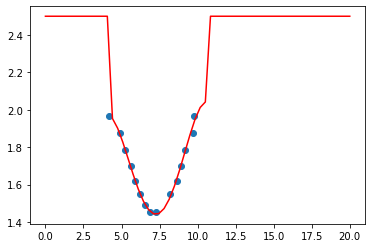

In [ ]:
plt.scatter([ x[0] for x in stable], [ x[1] for x in stable])
plt.plot(xnew, func_new(xnew, *popt), 'r-')

In [ ]:
def stable_crop(file,col,frac, a,b,c,d,e):
  boolean_array = file['Mg'] < func_new(file['R'],a,b,c,d,e)
  # print(boolean_array)
  boolean_new = []
  boolean_element = boolean_array[0]
  # print(boolean_array)
  i=0
  while boolean_element == True and i<len(boolean_array):
    boolean_element = boolean_array[i]
    boolean_new.append(boolean_element)
    i=i+1
  while i < len(boolean_array):
    boolean_new.append(False)
    i = i+1
  boolean_array = boolean_new
  # print(boolean_array)

  for i in range(len(boolean_array)):

    if boolean_array[i] == True:
      R,M = file['R'][i], file['Mg'][i]
      # print(R,M)
      plt.scatter(file['R'][i], file['Mg'][i],marker='.',s=3, c = col,label = '{}%'.format(frac) if i == 0 else "" )

    elif boolean_array[i] == False:
      R,M = file['R'][i], file['Mg'][i]
      # print(R, M, func(file['R'][i],a,b,c,d,e))
      

    # if file['M'] < func(file['R'], a,b,c,d,e):
    #   plt.scatter(file['R'], file['Mg'],marker='.',s=3, c = 'b' )
    # else:
    #   plt.scatter(file['R'], file['Mg'],marker='.',s=3, c = 'r' )
  

  return


In [ ]:
data_con = [data_con0,data_con1,data_con2, data_con3,data_con4, data_con5, data_con6, data_con7, data_con8,data_con9,data_con10]
data_frac = [1,10,20,30,40,50,60,70,80,90,99 ]
data_colours = ['b','g','r','c','m','y','indigo','pink','lime','brown','orange']

In [ ]:
# for i in data_con:
#   stable_crop(i,*popt)

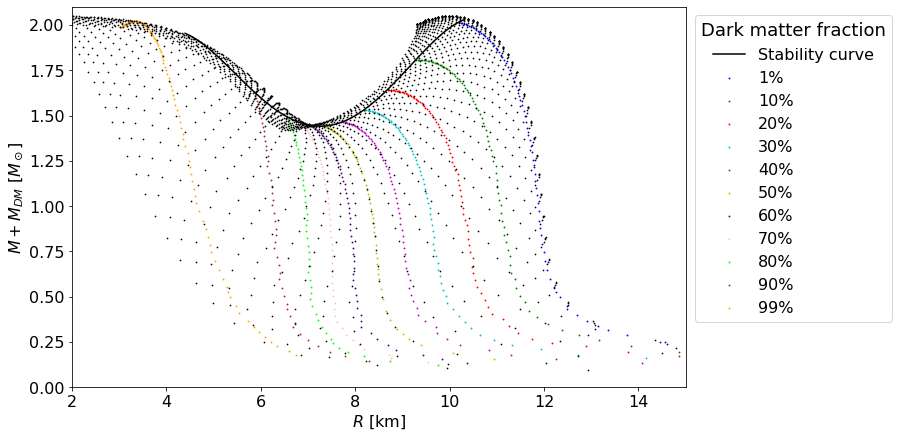

In [ ]:
plt.figure(figsize= (11,7))
for i,j,k in zip(data_con,data_frac,data_colours):
  stable_crop(i,k,j,*popt)
# stable_crop(data_con5,*popt)

plt.xlabel(r'$R$ [km]', size = 16) # add plot labels, etc.
plt.ylabel(r'$M+M_{DM}$ [$M_\odot$]', size = 16)
plt.plot(xnew2, func(xnew2, *popt), 'k-',label = 'Stability curve')
# plt.scatter(mrl_data_sly['R'][0::48],(mrl_data_sly['Mg'])[0::48], label = '{} R0'.format('sly'), marker = 'o', color = 'k', s = 10)
plt.scatter(dat['R'],dat['Mg'],marker='.',s=2,c='k')


plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(bbox_to_anchor=(1.35, 1), fontsize = 16, title='Dark matter fraction',title_fontsize=18 )
plt.xlim(2,15)
plt.ylim(0,2.1)
plt.show()
